# **Libraries**

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import njit
from scipy.optimize import curve_fit
from ase import Atoms
from ase.visualize import view
from ase.io.trajectory import Trajectory

# ***Global Optima of Lennard-Jones Cluster***

## Constant values

In [87]:
epsilon = 1.0
sigma = 1.0
rc = 2.5 * sigma
inv_rc_12 = (sigma/rc)**12
inv_rc_6 = (sigma/rc)**6

## Random Positions Initialization

In [88]:
def initialize_positions(N, L):
    return np.random.uniform(-L/2, L/2, size=(N,3))

## Potential Energy Calculation

In [ ]:
#@njit
def calculate_energy(positions, L, include_cohesive=True):
    N = len(positions)
    total_energy = 0.0
    alpha = 0.0001 * (N**(-2/3))

    for i in range(N):
        if include_cohesive:
            total_energy += alpha * (np.linalg.norm(positions[i], 2)**2)   # Cohesive energy
        for j in range(i+1, N):   # Pairwise
            rij = positions[j] - positions[i]
            #print(rij)
            rij -= np.round(rij / L) * L   # Periodic boundary condition
            #print(rij)
            rij_normalized = max(np.linalg.norm(rij), 1e-10)   # Normalized distance, clip the value when it becomes too small
            #print(rij_normalized)

            if rij_normalized <= rc:   # Ignore the energy at r_cut
                inv_rij_12 = (sigma/rij_normalized)**12
                inv_rij_6 = (sigma/rij_normalized)**6
                total_energy += 4 * epsilon * (inv_rij_12 - inv_rij_6 - inv_rc_12 + inv_rc_6)
    
    return total_energy

## Forces Calculation

In [ ]:
#@njit
def calculate_forces(positions, L):
    N = len(positions)
    forces = np.zeros_like(positions)
    alpha = 0.0001 * N**(-2/3)

    forces += 2 * alpha * positions   # Cohesive forces
    for i in range(N):
        for j in range(i+1, N):   # Pairwise
            rij = positions[j] - positions[i]
            rij -= np.round(rij / L) * L   # Periodic boundary condition
            rij_normalized = max(np.linalg.norm(rij, 2), 1e-10)   # Normalized distance, clip the values when it becomes too small
            
            if rij_normalized <= rc:   # Ignore the forces at r_cut
                inv_rij_12 = (sigma/rij_normalized)**12
                inv_rij_6 = (sigma/rij_normalized)**6
                f_magnitude = -24 * epsilon / rij_normalized * (2*inv_rij_12 - inv_rij_6)
                # Clip the magnitude of forces when it becomes too big or too small
                if f_magnitude < -10e4:
                    f_magnitude = -10e4
                if f_magnitude > 10e4:
                    f_magnitude = 10e4
                # Active and reactive forces on each pair of particles
                forces[i] -= f_magnitude * rij / rij_normalized
                forces[j] += f_magnitude * rij / rij_normalized

    return forces

### *Alternative: Combined function to compute Potential Energy and Forces*

In [ ]:
#@njit
def calculate_energy_and_forces(positions, L, include_cohesive):
    N = len(positions)
    total_energy = 0.0
    forces = np.zeros_like(positions)
    alpha = 0.0001 * N**(-2/3)

    forces += 2 * alpha * positions   # Cohesive forces
    for i in range(N):
        if include_cohesive == True:
            total_energy += alpha * (np.linalg.norm(positions[i], 2)**2)   # Cohesive energy
        for j in range(i+1, N):   # Pairwise
            rij = positions[j] - positions[i]
            rij -= np.round(rij / L) * L   # Periodic boundary condition
            rij_normalized = max(np.linalg.norm(rij, 2), 1e-10)   # Normalized distance, clip the value when it becomes too small
            
            if rij_normalized <= rc:   # Ignore the energy and forces at r_cut
                inv_rij_12 = (sigma/rij_normalized)**12
                inv_rij_6 = (sigma/rij_normalized)**6

                total_energy += 4 * epsilon * (inv_rij_12 - inv_rij_6 - inv_rc_12 + inv_rc_6)

                f_magnitude = -24 * epsilon / rij_normalized * (2*inv_rij_12 - inv_rij_6)
                # Clip the magnitude of forces when it becomes too big or too small
                if f_magnitude < -10e4:
                    f_magnitude = -10e4
                if f_magnitude > 10e4:
                    f_magnitude = 10e4
                # Active and reactive forces on each pair of particles
                forces[i] -= f_magnitude * rij / rij_normalized
                forces[j] += f_magnitude * rij / rij_normalized
    
    return total_energy, forces

## Line Search Method

In [ ]:
LStol = 1e-8
MaxLSSteps = 100000
delta = 0.001

#@njit
def perform_line_search(positions, search_direction, L, delta, LStol, MaxLSSteps, include_cohesive):
    r0 = np.copy(positions)
    r1 = r0 + delta * search_direction
    r2 = r1 + delta * search_direction

    U0 = calculate_energy(r0, L, include_cohesive)
    U1 = calculate_energy(r1, L, include_cohesive)
    U2 = calculate_energy(r2, L, include_cohesive)
    for _ in range(MaxLSSteps):
        if U2 > U1 and U0 > U1:   # Find a valid bracket
        # When found a suitable bracket, refine using bisection method
            rm1 = (r0 + r1) / 2
            rm2 = (r1 + r2) / 2
            Um1 = calculate_energy(rm1, L, include_cohesive)
            Um2 = calculate_energy(rm2, L, include_cohesive)
            if Um1 >= U1 and Um2 >= U1:
                if abs(Um1 - U1) < LStol * abs(Um1):
                    break
                r0, U0 = rm1, Um1
                r2, U2 = rm2, Um2
            elif Um1 < U1:
                r2, U2 = r1, U1
                r1, U1 = rm1, Um1
            else:
                r0, U0 = r1, U1
                r1, U1 = rm2, Um2

        else:   # Shift the bracket
            r0, U0 = r1, U1
            r1, U1 = r2, U2
            r2 += delta * search_direction
            U2 = calculate_energy(r2, L, include_cohesive)

    return r1, U1

## Conjugate Gradient Method

In [ ]:
ECtol = 1e-10
MaxCGSteps = 100000

#@njit
def perform_conjugate_gradient_minimization(positions, L, ECtol, MaxCGSteps):
    N = len(positions)
    trajectory = [positions]   # Store the positions at each iteration for visualizing the trajectory

    f_i_minus_1 = calculate_forces(positions, L)
    direction = -f_i_minus_1
    for i in range(N):
        direction[i] /= np.linalg.norm(f_i_minus_1[i])
    U_i_minus_1 = calculate_energy(positions, L, include_cohesive=True)
    energy_evolution = [U_i_minus_1]   # Store the minimal potential energy for plotting the energy evolution
    
    for CGSteps in range(0, MaxCGSteps+1):
        #print(CGSteps, U_i_minus_1)
        positions, U_i = perform_line_search(positions, direction, L, delta, LStol, MaxLSSteps, include_cohesive=True)
        trajectory.append(positions)
        energy_evolution.append(U_i)
        if abs(U_i - U_i_minus_1) < ECtol * abs(U_i) or U_i > U_i_minus_1:   # Terminate when tolerance criteria is met or overshooting
            if U_i > U_i_minus_1:
                trajectory.pop(len(trajectory) - 1)
                energy_evolution.pop(len(energy_evolution) - 1)
            break
        
        f_i = calculate_forces(positions, L)
        for i in range(N):
            gamma = np.dot((f_i[i] - f_i_minus_1[i]), f_i[i]) / np.dot(f_i_minus_1[i], f_i_minus_1[i])
            direction[i] = -(f_i[i] + gamma * direction[i])
            direction[i] /= np.linalg.norm(direction[i])
       
        f_i_minus_1 = f_i
        U_i_minus_1 = U_i

    return U_i, CGSteps, energy_evolution, trajectory

In [106]:
density = 0.001
N = 2
L = (N/density) ** (1/3)
positions = initialize_positions(N, L)
U_min, CGSteps, energy_evo, traj = perform_conjugate_gradient_minimization(positions, L, ECtol, MaxCGSteps)
last_direction = - calculate_forces(traj[-1], L)
for i in range(N):
    last_direction[i] /= np.linalg.norm(last_direction[i])
last_positions, U_min = perform_line_search(traj[-1], last_direction, L, delta, LStol, MaxLSSteps, include_cohesive=False)
energy_evo.append(U_min)
traj.append(last_positions)
print(energy_evo)

[0.003128227927552141, -0.02675081815277822, -0.026750821634147423, -0.9834026898060425, -0.9834152612778035, -0.9835294221207628, -0.9835296255283722, -0.9836817272878724]


## Simulation

In [115]:
density = 0.001

# Define function of a single simulation
def run_simulation(N):
    L = (N/density) ** (1/3)
    positions = initialize_positions(N, L)
    U_min, CGSteps, energy_evolution, trajectory = perform_conjugate_gradient_minimization(positions, L, ECtol, MaxCGSteps)

    # Perform a line search at the end where cohesive term is dropped
    last_direction = - calculate_forces(trajectory[-1], L)
    for i in range(N):
        last_direction[i] /= np.linalg.norm(last_direction[i])
    last_positions, U_min = perform_line_search(trajectory[-1], last_direction, L, delta, LStol, MaxLSSteps, include_cohesive=False)
    energy_evolution.append(U_min)
    trajectory.append(last_positions)
    return U_min, CGSteps+1, energy_evolution, trajectory

# Define function of simulations for an N, integrating parallelism
def simulation_for_N(N, simulation_num):
    simulations = Parallel(n_jobs=-1)(delayed(run_simulation)(N) for _ in range(simulation_num))
    min_energy = np.inf
    for res in simulations:
        if res[0] < min_energy:
            min_energy = res[0]
            CGSteps = res[1]
            energy_revolution = res[2]
            trajectory = res[3]
    return min_energy, CGSteps, energy_revolution, trajectory


N_range = range(2,26)
simulation_num = 1000
min_energy_list = []
CGSteps_list = []
energy_evolution_list = []
trajectory_list = []

# Execute the simulations and return the results
for N in(N_range):
    min_energy, CGSteps, energy_evolution, trajectory = simulation_for_N(N, simulation_num)
    print(f'N={N}, MinEnergy={min_energy}, CGSteps={CGSteps}')
    min_energy_list.append(min_energy)
    CGSteps_list.append(CGSteps)
    energy_evolution_list.append(energy_evolution)
    trajectory_list.append(trajectory)

N=2, MinEnergy=-0.9836831088619851, CGSteps=4
N=3, MinEnergy=-2.951049326477965, CGSteps=18
N=4, MinEnergy=-5.902097887548588, CGSteps=173
N=5, MinEnergy=-8.94064091513207, CGSteps=229
N=6, MinEnergy=-12.057861481778929, CGSteps=232


KeyboardInterrupt: 

## Plotting Task 2

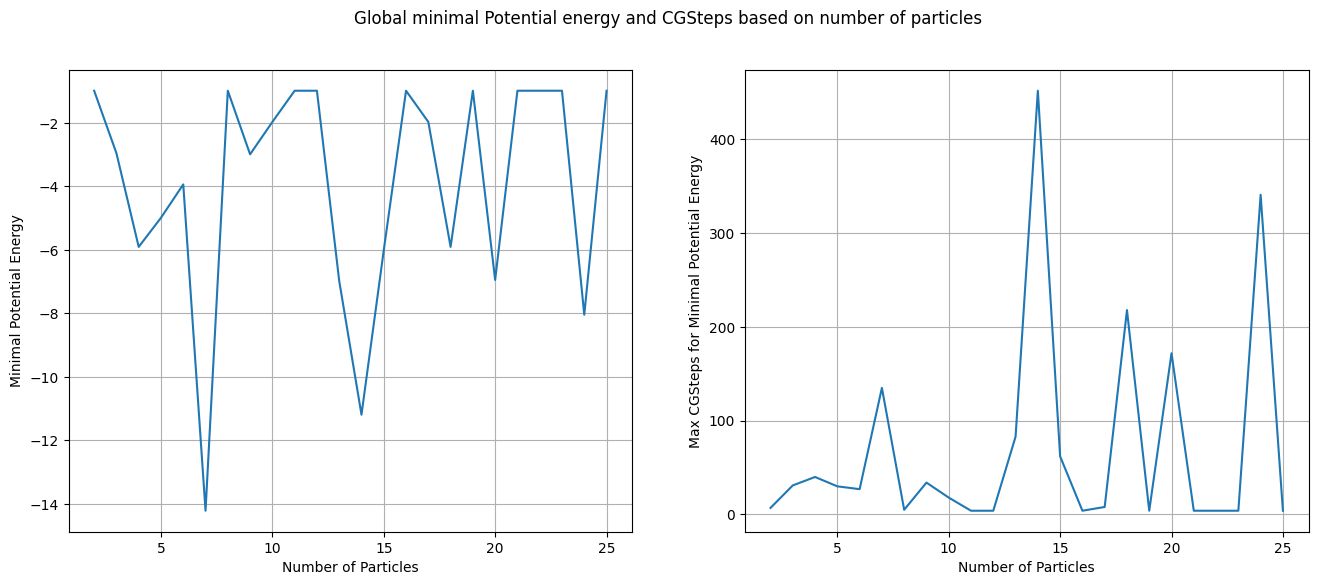

In [48]:
N_list = np.arange(2, 26)

plt.figure(figsize=(16,6))
# Plot global minimum potential energy based on number of particles
plt.subplot(1, 2, 1)
plt.plot(N_list, min_energy_list)
plt.xlabel('Number of Particles')
plt.ylabel('Minimal Potential Energy')
plt.grid(True)

# Plot num of CGSteps based on number of particles
plt.subplot(1, 2, 2)
plt.plot(N_list, CGSteps_list)
plt.xlabel('Number of Particles')
plt.ylabel('Max CGSteps for Minimal Potential Energy')
plt.grid(True)


plt.suptitle('Global minimal Potential energy and CGSteps based on number of particles')
plt.savefig('task2')

## Plotting and Visualizing Task 3

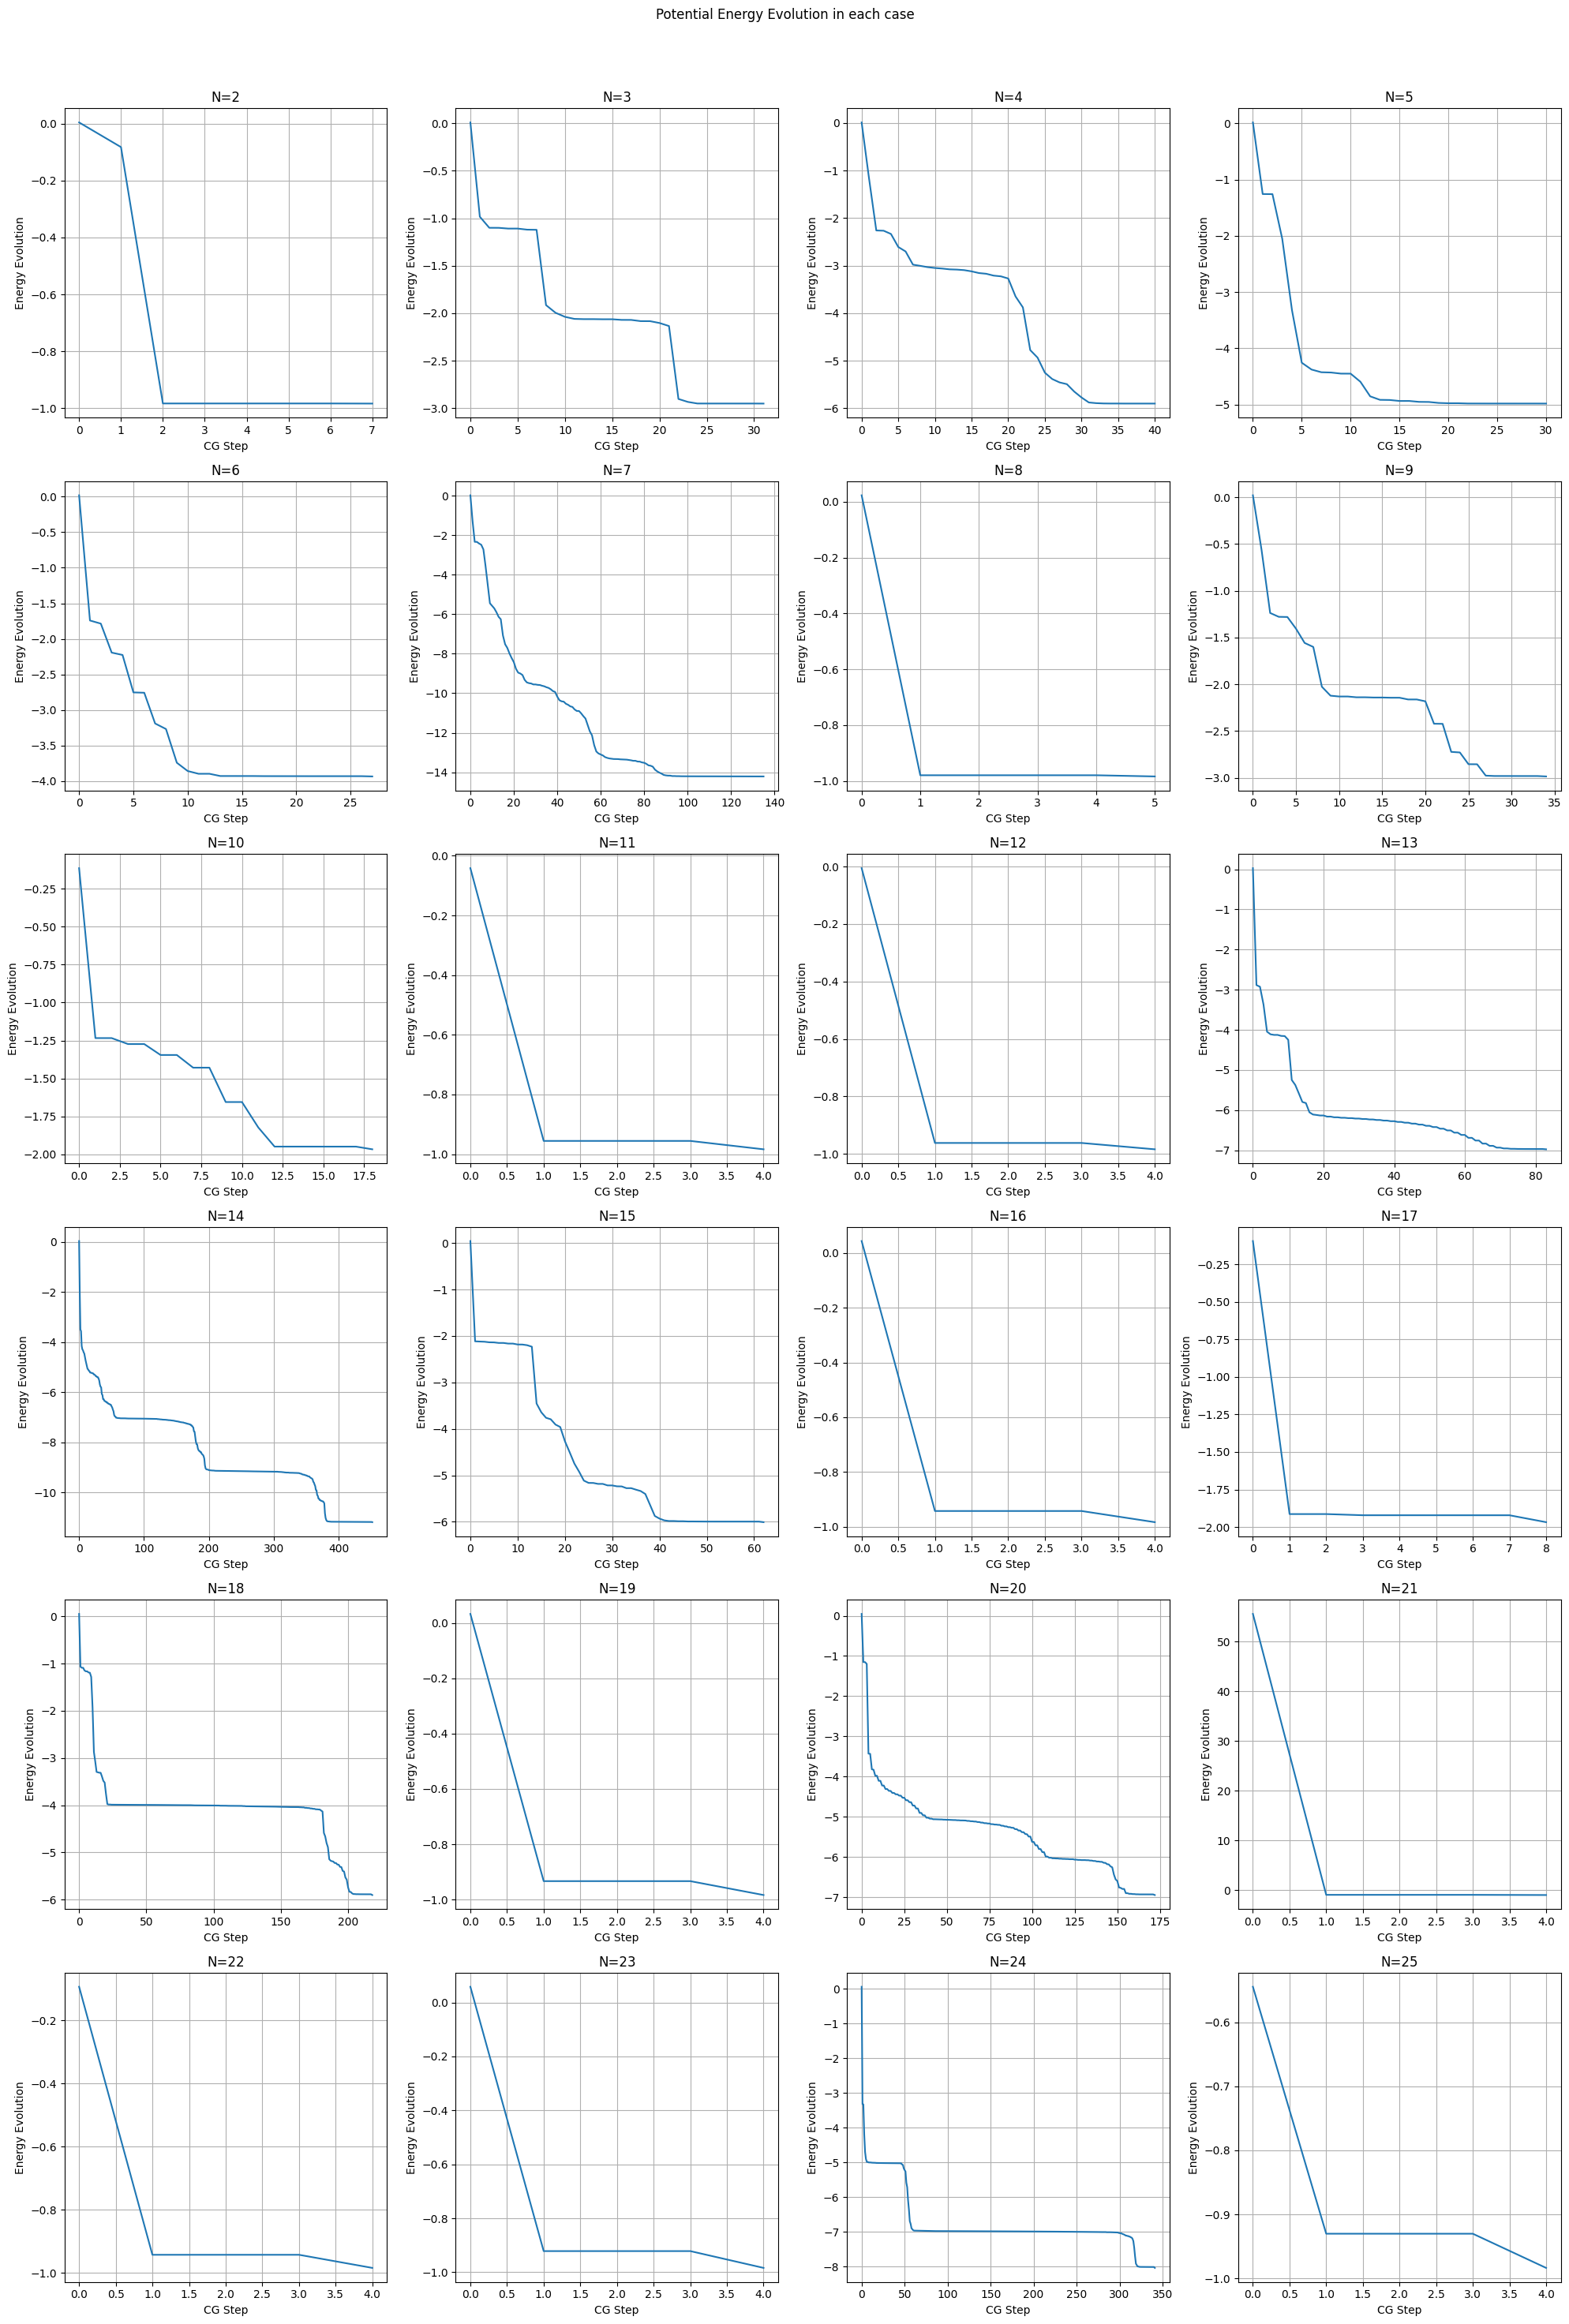

In [46]:
# Plot the evolution of Potential energy at each conjugate gradient step
plt.figure(figsize=(20, 30))
for N in N_list:
    index = N - 2
    plt.subplot(6, 4, index+1)
    plt.plot(np.arange(0, CGSteps_list[index]+1), energy_evolution_list[index])
    plt.xlabel('CG Step')
    plt.ylabel('Energy Evolution')
    plt.title(f'N={N}')
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.suptitle('Potential Energy Evolution in each case')
plt.savefig('task3')

In [ ]:
# Visualize the trajectory of a cluster with 14 particles
traj = Trajectory('nano.traj', 'w')
i = 0
fac = 1.0
pos_list_C14 = trajectory_list[12]
while i < len(pos_list_C14):
    nano = Atoms('C14', pos_list_C14[i]*fac)
    i += 1
    traj.write(nano)

## Plotting Task 4

Fitted values: a = -0.02140481574898967, b = -3.1362933949272263, c = 0.9839066017345607


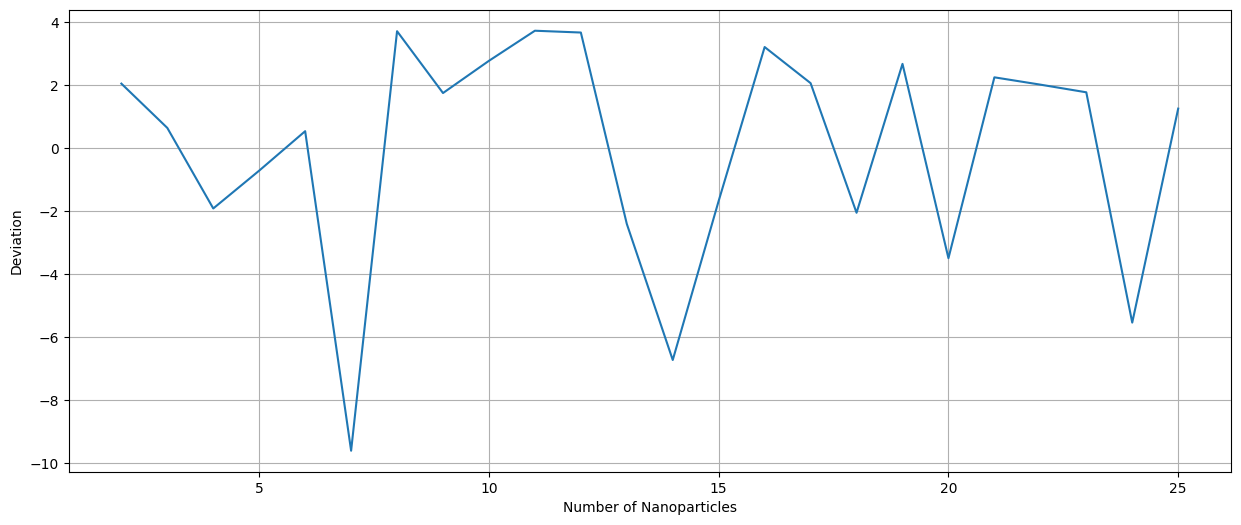

In [ ]:
# Define the curve fitting function
def U_macro(N, a, b, c):
    return a + b * (N**(2/3)) + c * N

# Perform the least squares fitting
params, params_covariance = curve_fit(U_macro, N_list, min_energy_list)

# Extract fitted parameters
a, b, c = params
print(f"Fitted values: a = {a}, b = {b}, c = {c}")

deviation_list = min_energy_list - U_macro(N_list, *params)

plt.figure(figsize=(15, 6))
# Plot the data and the fitted curve
plt.plot(N_list, deviation_list)
plt.xlabel("Number of Nanoparticles")
plt.ylabel("Deviation")
plt.grid(True)
plt.savefig('task4')